In [83]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [95]:
feature_type = "network" # "plant" / "network"
networks_type = "binarized_weighted" # "binary" / "weighted" / "binarized_weighted"

pollinatos_taxonomic_level_across_networks_path = "../../data/features/taxonomic_features/net_to_pollinators_taxonomic_classification.csv"
features_path = f"../../data/features/{feature_type}/{networks_type}/features_with_classification.csv"
network_features = ["weighted NODF", # nestedness measures
                     "weighted connectance",
                     "modularity"]
plant_features = ["partner.diversity", # shanon diversity
                     "d", # speciality index d',
                     "normalised.degree",
                     "weighted.betweenness", # centrality,
                     "weighted.closeness",
                     "hubbiness_score"]

In [96]:
pollinators_taxonomic_level_across_networks = pd.read_csv(pollinatos_taxonomic_level_across_networks_path)
pollinators_taxonomic_level_across_networks.network_id = pollinators_taxonomic_level_across_networks.network_id.astype(np.int16)   
pollinators_taxonomic_level_across_networks = pollinators_taxonomic_level_across_networks.query(f"network_type == '{networks_type if not 'weighted' in networks_type else 'weighted'}'")
print(f"# networks with taxonomic classification data = {pollinators_taxonomic_level_across_networks.shape[0]:,}")
pollinators_taxonomic_level_across_networks.notna().sum() / pollinators_taxonomic_level_across_networks.shape[0]

# networks with taxonomic classification data = 538


network_type         1.000000
network_id           1.000000
rank_name            1.000000
num_ranks            1.000000
highest_rank_name    0.933086
dtype: float64

In [97]:
features = pd.read_csv(features_path)
if "network_id" in features.columns and "network" in features.columns:
    features.drop("network_id", axis=1, inplace=True)
features = features.rename(columns={"network": "network_id"})
print(f"# {networks_type} networks = {len(features.network_id.unique()):,}")
features = features.merge(pollinators_taxonomic_level_across_networks[["network_id", "num_ranks", "highest_rank_name"]], on="network_id", how="left")
features = features.rename(columns={"num_ranks": "num_pollinator_taxonomic_ranks", "highest_rank_name": "highest_pollinator_rank"}).drop([c for c in features.columns if "Unnamed" in c or c.endswith(".1")], axis=1)
features = features.loc[:,~features.columns.duplicated()].copy()
features = features[[ c for c in features.columns if not "standardized_ " in c]]
features.to_csv(features_path, index=False)
features.notna().sum() / features.shape[0]

# binarized_weighted networks = 534


Plant                             1.000000
connectance                       1.000000
web asymmetry                     1.000000
links per species                 1.000000
number of compartments            1.000000
                                    ...   
num_classified                    1.000000
num_polyploids                    1.000000
num_diploids                      1.000000
num_pollinator_taxonomic_ranks    1.000000
highest_pollinator_rank           0.932584
Length: 117, dtype: float64

In [98]:
if feature_type == "plant":
    df_to_plot = features.groupby(["original_name", "highest_pollinator_rank"]).mean()
else:
    df_to_plot = features.groupby(["network_id", "highest_pollinator_rank"]).mean()
    df_to_plot["is_polyploid_frac_more_than_half"] = df_to_plot.conservative_is_polyploid_poly_frac > 0.5

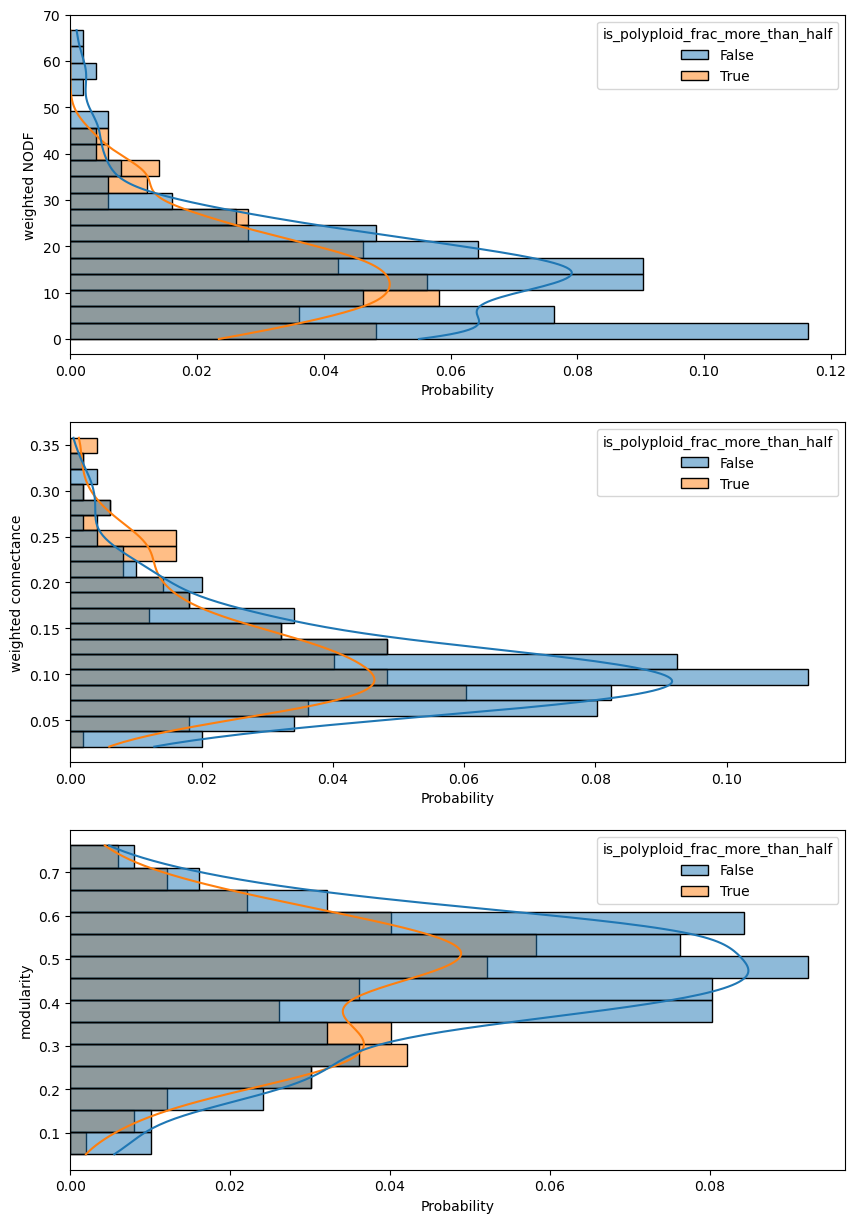

In [99]:
features_to_plot = network_features if feature_type == "network" else plant_features
color_by = "is_polyploid" if feature_type == "plant" else "is_polyploid_frac_more_than_half"
fig, axes = plt.subplots(nrows=len(features_to_plot), ncols=1, figsize=(10, 5*len(features_to_plot)))
for feature in features_to_plot:
    sns.histplot(data=df_to_plot, y=feature, hue=color_by, stat="probability", kde=True, ax=axes[features_to_plot.index(feature)])